In [1]:
import numpy as np
np.random.seed(42)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
data=pd.read_json("/content/drive/My Drive/sarcasm/Sarcasm_Headlines_Dataset.json", lines=True)

In [0]:
text = data.headline.tolist()
label = np.array(data.is_sarcastic.tolist())

In [4]:
import keras

from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
seq=t.fit_on_texts(text)

Using TensorFlow backend.


In [0]:
sequences = t.texts_to_sequences(text)

In [6]:
embeddings_index = {}
f = open('/content/drive/My Drive/sarcasm/glove.6B.200d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [0]:
vocab_size=len(t.word_index)
word_index = t.word_index

In [0]:
EMBEDDING_DIM = embeddings_index.get('the').shape[0]
embedding_matrix = np.zeros((vocab_size+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
embedding_matrix.shape

(29657, 200)

In [0]:
from keras.preprocessing.sequence import pad_sequences
train=pad_sequences(sequences, maxlen=100,padding='pre')

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_testVal,y_train,y_testVal=train_test_split(train,label,test_size=0.3,stratify=label)
X_val,X_test,y_val,y_test=train_test_split(X_testVal,y_testVal,test_size=0.5,stratify=y_testVal)

In [13]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(return_indices=True)
X_rus_train, y_rus_train, id_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [66]:
X_rus_train.shape

(20978, 100)

In [0]:
from keras.callbacks import History,EarlyStopping
hist=History()
early=EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=False)

In [0]:
from keras.layers import Embedding, CuDNNLSTM, Dense, Dropout, Bidirectional, Flatten
from keras.models import Sequential
from keras import optimizers
import keras.utils as ku
from keras import regularizers
opt=optimizers.adam(lr=1.5e-5)
model=Sequential()
model.add(Embedding(input_dim=29657,output_dim=200,input_shape=(100,),embeddings_initializer='uniform',weights= [embedding_matrix]))
model.add(Bidirectional(CuDNNLSTM(20,return_sequences=True)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [98]:
model.fit(X_rus_train,ku.to_categorical(y_rus_train,num_classes=2),epochs=15,
    validation_data=(X_val,ku.to_categorical(y_val,num_classes=2)),callbacks=[hist,early],shuffle=True)

Train on 20978 samples, validate on 4006 samples
Epoch 1/15
20978/20978 [==============================] - 33s 2ms/step - loss: 0.6888 - acc: 0.5360 - val_loss: 0.6804 - val_acc: 0.6101
Epoch 2/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.6777 - acc: 0.5878 - val_loss: 0.6692 - val_acc: 0.6613
Epoch 3/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.6588 - acc: 0.6449 - val_loss: 0.6439 - val_acc: 0.6955
Epoch 4/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.6179 - acc: 0.7064 - val_loss: 0.5882 - val_acc: 0.7229
Epoch 5/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.5405 - acc: 0.7486 - val_loss: 0.5178 - val_acc: 0.7516
Epoch 6/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.4805 - acc: 0.7748 - val_loss: 0.4835 - val_acc: 0.7768
Epoch 7/15
20978/20978 [==============================] - 30s 1ms/step - loss: 0.4462 - acc: 0.7934 - val_loss: 0.4651 - val_acc:

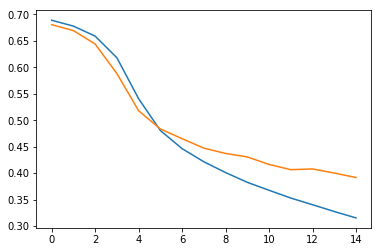

In [99]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [0]:
y_te_pred=model.predict_classes(X_test)
y_tr_pred=model.predict_classes(X_train)

In [101]:
from sklearn.metrics import accuracy_score,f1_score,precision_recall_fscore_support,classification_report
precision, recall, fscore, support = precision_recall_fscore_support(y_te_pred, y_test)
print(classification_report(y_te_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2142
           1       0.83      0.79      0.81      1865

    accuracy                           0.83      4007
   macro avg       0.83      0.83      0.83      4007
weighted avg       0.83      0.83      0.83      4007



In [102]:
precision, recall, fscore, support = precision_recall_fscore_support(y_tr_pred, y_train)
print(classification_report(y_tr_pred, y_train))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     10118
           1       0.87      0.83      0.85      8578

    accuracy                           0.87     18696
   macro avg       0.87      0.87      0.87     18696
weighted avg       0.87      0.87      0.87     18696

